# Image Baseline

In [2]:
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm.notebook import tqdm # Progress bars

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image

import os
import random

from src.data import load_omnimed_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load the Dataset

### Load the Base Dataset

In [3]:
train_df, val_df, test_df = load_omnimed_dataset()

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

# Check for image overlap
print("Overlap train-test:", len(set(train_df['image_path']) & set(test_df['image_path'])))
print("Overlap train-val:", len(set(train_df['image_path']) & set(val_df['image_path'])))


Resolving data files:   0%|          | 0/42 [00:00<?, ?it/s]

Train size: 42369
Validation size: 7471
Test size: 5547
Overlap train-test: 0
Overlap train-val: 0


### Create Image-Only Dataframes

In [4]:
def create_image_df(df):
    # Extract the text of the correct option using gt_label
    df = df.copy()
    df['gt_text'] = df.apply(lambda row: row[row['gt_label']], axis=1)
    
    # Keep only image_path and gt_text for the image-only baseline
    return df[['image_path', 'gt_text']]

train_img_df = create_image_df(train_df)
val_img_df = create_image_df(val_df)
test_img_df = create_image_df(test_df)

### Build the Label Space

In [5]:
all_labels = pd.concat([train_img_df, val_img_df, test_img_df])['gt_text'].unique()
all_labels = sorted(all_labels)
label_to_idx = {label: i for i, label in enumerate(all_labels)}
idx_to_label = {i: label for label, i in label_to_idx.items()}

# Map text to integer labels
for df in [train_img_df, val_img_df, test_img_df]:
    df['label_idx'] = df['gt_text'].map(label_to_idx)

# Verify label distribution
print("Number of unique labels:", len(all_labels))

Number of unique labels: 156


## Image Dataset Setup

### Define Image Transforms

In [6]:
# Training transforms (includes augmentation)
train_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),               # Resize image
    transforms.RandomHorizontalFlip(),                # Augment: flip
    transforms.RandomRotation(10),            # Augment: slight rotation
    models.ResNet18_Weights.DEFAULT.transforms(),     # Use normalization from pre-trained model
])

# Validation / Test transforms (no augmentation)
val_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    models.ResNet18_Weights.DEFAULT.transforms()
])

### Create Image Dataset

In [7]:
class OmniMedImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label_idx']

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
train_dataset = OmniMedImageDataset(train_img_df, transform=train_image_transform)
val_dataset = OmniMedImageDataset(val_img_df, transform=val_image_transform)
test_dataset = OmniMedImageDataset(test_img_df, transform=val_image_transform)

### Create Data Loaders

In [9]:
# Define batch_size
# TODO: Add to config.py as constant with optional override
batch_size = 32
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# Quick check
print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 1325
Validation batches: 234
Test batches: 174


In [10]:
for i, (images, labels) in enumerate(train_loader):
    print(i, images.shape, labels.shape)
    if i == 2:
        break

0 torch.Size([32, 3, 224, 224]) torch.Size([32])
1 torch.Size([32, 3, 224, 224]) torch.Size([32])
2 torch.Size([32, 3, 224, 224]) torch.Size([32])


## Model Setup

### Define the Model

In [11]:
# Model
num_classes = len(label_to_idx)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes) # Replace final layer
model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

### Training Loop

In [24]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# TODO: Add to config.py as constant with optional override
num_epochs = 3

best_val_acc = 0.0
os.makedirs("models", exist_ok=True)
best_model_path = os.path.join("models", "resnet18_best.pth")

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")

    # Training
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss /= total_train
    train_acc = correct_train / total_train
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    
    # Vaidation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss /= total_val
    val_acc = correct_val / total_val
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with val_acc={best_val_acc:.4f}")

    # Step the scheduler
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)



=== Epoch 1/3 ===


Training:   0%|          | 0/1325 [00:00<?, ?it/s]

Train Loss: 0.8755, Train Accuracy: 0.7021


Validation:   0%|          | 0/234 [00:00<?, ?it/s]

Validation Loss: 1.1307, Validation Accuracy: 0.6407
Saved best model with val_acc=0.6407

=== Epoch 2/3 ===


Training:   0%|          | 0/1325 [00:00<?, ?it/s]

Train Loss: 0.6939, Train Accuracy: 0.7620


Validation:   0%|          | 0/234 [00:00<?, ?it/s]

Validation Loss: 1.0964, Validation Accuracy: 0.6616
Saved best model with val_acc=0.6616

=== Epoch 3/3 ===


Training:   0%|          | 0/1325 [00:00<?, ?it/s]

Train Loss: 0.5985, Train Accuracy: 0.7956


Validation:   0%|          | 0/234 [00:00<?, ?it/s]

Validation Loss: 1.1436, Validation Accuracy: 0.6592


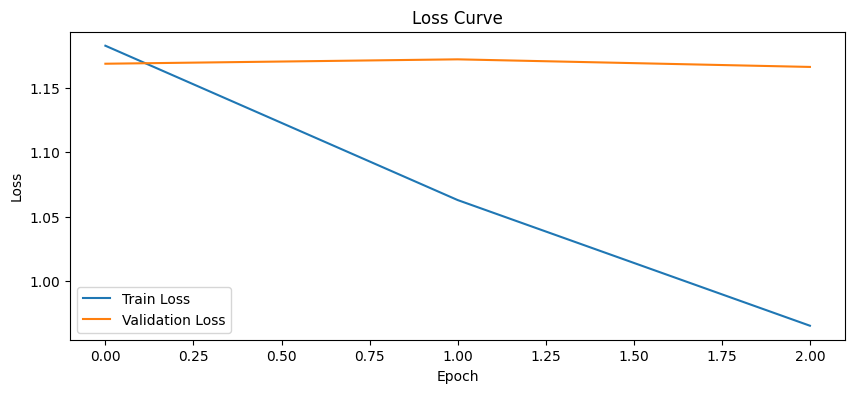

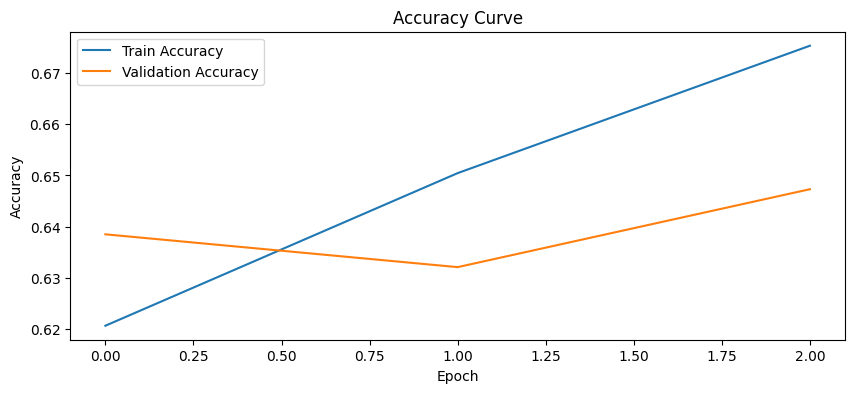

In [17]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()


### Testing Loop

In [18]:
# Load best model before testing
model.load_state_dict(torch.load(best_model_path))
model.eval()
print(f"Loaded best model from {best_model_path}")

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Accuracy
accuracy = np.mean(y_true == y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Loaded best model from models/resnet18_best.pth


Testing:   0%|          | 0/174 [00:00<?, ?it/s]

Test Accuracy: 0.6319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9776908].


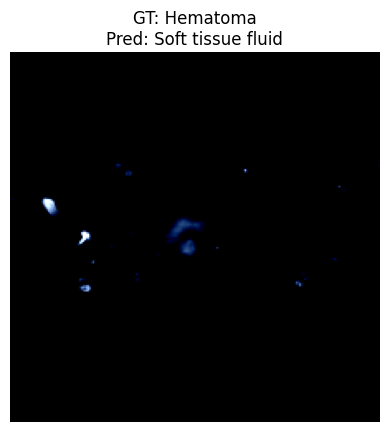

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.64].


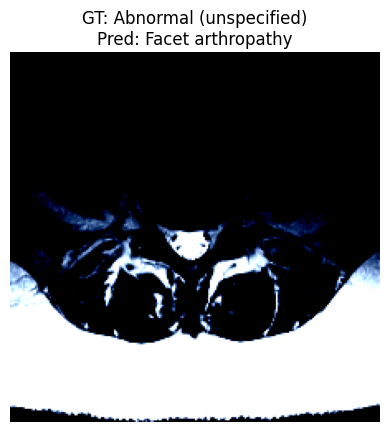

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


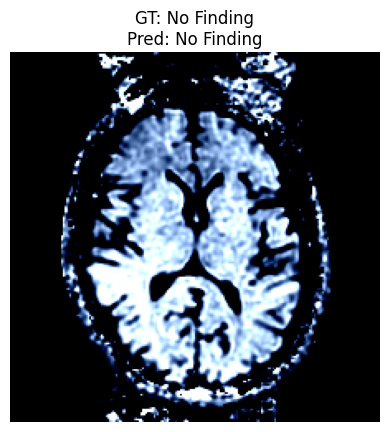

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.64].


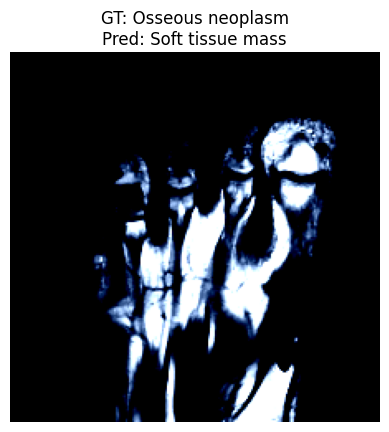

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


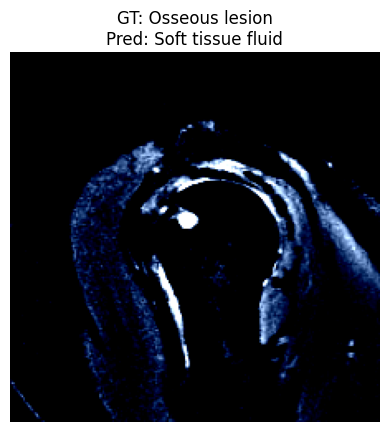

In [21]:
# Choose random indices
random_indices = random.sample(range(len(test_dataset)), 5)

for idx in random_indices:
    image, label = test_dataset[idx]
    image_tensor = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, pred = torch.max(output, 1)

    true_label = idx_to_label[label]
    predicted_label = idx_to_label[pred.item()]

    # Display image and labels
    img_np = image.permute(1, 2, 0).numpy()  # CHW -> HWC
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"GT: {true_label}\nPred: {predicted_label}")
    plt.show()


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Test Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Test Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Test F1 (macro):        {f1_score(y_true, y_pred, average='macro'):.4f}")


Test Accuracy:  0.6319
Test Precision (macro): 0.3733
Test Recall (macro):    0.3537
Test F1 (macro):        0.3255


/home/gio/dev/MediVision-OmniMedVQA/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
